# CMB B-mode パワースペクトルからのテンソル-スカラー比 $r$ の推定

## 基礎理論

### モデル

CMBのB-modeパワースペクトル $C_\ell^{BB}$ は、レンズ効果成分とテンソル成分の和として表される：

$$
C_\ell = r \cdot C_\ell^{\rm tens} + C_\ell^{\rm lens}
$$

ここで：
- $r$：テンソル-スカラー比（推定したいパラメータ）
- $C_\ell^{\rm tens}$：$r=1$ のときのテンソルモードパワースペクトル
- $C_\ell^{\rm lens}$：レンズ効果によるB-modeパワースペクトル

### 観測データ

観測されたパワースペクトル $\hat{C}_\ell$ は、真のパワースペクトルにシステマティックエラーを加えたものとして表される：

$$
\hat{C}_\ell = C_\ell^{\rm sys} + C_\ell^{\rm lens}
$$

ここで $C_\ell^{\rm sys}$ は観測されたシステマティック成分。

## 尤度関数

### 対数尤度

テンソル-スカラー比 $r$ の尤度関数は以下で与えられる（PTEP 2023 論文 Sec. 5.3.2 に基づく）：

$$
\ln \mathcal{L}(r) = \sum_{\ell=2}^{\ell_{\rm max}} \left[ -\frac{1}{2}(2\ell+1) \left( \frac{\hat{C}_\ell}{C_\ell(r)} + \ln C_\ell(r) - \frac{2\ell-1}{2\ell+1} \ln \hat{C}_\ell \right) \right]
$$

ここで：
- $\hat{C}_\ell = C_\ell^{\rm sys} + C_\ell^{\rm lens}$（観測値）
- $C_\ell(r) = r \cdot C_\ell^{\rm tens} + C_\ell^{\rm lens}$（モデル）
- $(2\ell+1)$：多重極の縮退度

### 正規化された尤度

数値計算では、オーバーフローを避けるために正規化された尤度を使用：

$$
\mathcal{L}_{\rm norm}(r) = \exp\left[\ln \mathcal{L}(r) - \max_r \ln \mathcal{L}(r)\right]
$$

## 推定アルゴリズム

1. $r$ の初期探索範囲 $[r_{\rm min}, r_{\rm max}]$ を設定
2. グリッドサーチで尤度を最大化する $r$ を探す
3. 最大尤度の周辺に探索範囲を絞り込む
4. イテレーション毎に探索範囲を狭めて精度を向上：$[r_{\rm peak} - r_{\rm peak}/(2(j+1)), r_{\rm peak} + r_{\rm peak}/(2(j+1))]$
5. 収束したら最終的な $\Delta r = r_{\rm estimated}$ を返す

In [1]:
include("../src/est.jl")

_likelihood (generic function with 1 method)

In [2]:
reffpath_r0 = "../datautils/Cls_Planck2018_for_PTEP_2020_r0.fits"
reffpath_r1 = "../datautils/Cls_Planck2018_for_PTEP_2020_tensor_r1.fits"


"../datautils/Cls_Planck2018_for_PTEP_2020_tensor_r1.fits"

In [3]:
cl_r1 = read_planck_cl_as_TT_EE_BB_TE(reffpath_r1)
cl_r0 = read_planck_cl_as_TT_EE_BB_TE(reffpath_r0)

(ell = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9  …  3991, 3992, 3993, 3994, 3995, 3996, 3997, 3998, 3999, 4000], TT = [0.0, 0.0, 1069.293419526846, 506.20848946435257, 287.5289269122947, 183.6105920785657, 127.21670011201627, 93.53643327113096, 71.86244842100231, 57.20330586045431  …  1.4716516443044878e-6, 1.4680764623264682e-6, 1.4643392053849048e-6, 1.4607748322964086e-6, 1.4570485383492898e-6, 1.4534949470782567e-6, 1.4497795888398736e-6, 1.446232822452309e-6, 1.4425283746781492e-6, 1.4389962680924936e-6], EE = [0.0, 0.0, 0.03255988514082509, 0.020913058696171653, 0.010905818985451215, 0.004867772153031241, 0.0019498668803630476, 0.0007901868481994201, 0.00039517570390730413, 0.00025338829706793834  …  4.3154703005574754e-8, 4.3032178806949954e-8, 4.290977190467378e-8, 4.278826973113825e-8, 4.2667277389743774e-8, 4.25471875480256e-8, 4.2427212516141315e-8, 4.230853114823433e-8, 4.218996315696751e-8, 4.20722936186757e-8], BB = [0.0, 0.0, 1.9125178317013703e-6, 1.911056991117451e-6, 1.910213997

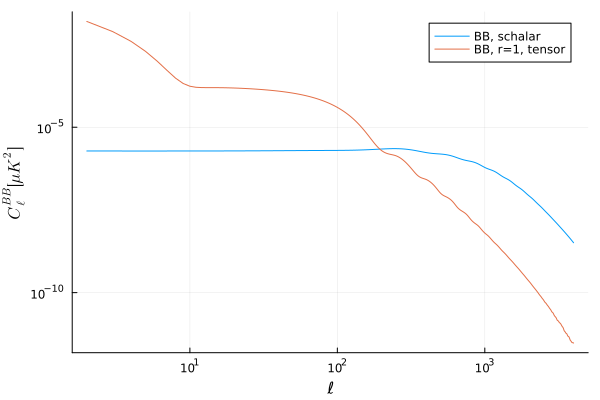

In [4]:
plot(
    xscale=:log, yscale=:log,
    xlabel="ℓ", ylabel=L"C_{\ell}^{BB} [\mu \rm{K}^{2}]",
    legend=:best
)

plot!(cl_r0.ell[3:end], cl_r0.BB[3:end], label="BB, schalar")
plot!(cl_r1.ell[3:end], cl_r1.BB[3:end], label="BB, r=1, tensor")


In [ ]:
function r_iterative_estimator(params::BBClModel, rmin, rmax, rresol,; itr = 1)
    r_ = range(rmin, rmax; length = Int(rresol))
    likelihoods = zeros(length(r_))
    cl_obs = params.cl_lens .+ params.cl_sys
    r_result = 0.0
    ell = params.ell
    for itr_idx in 1:itr
        r_ = range(rmin, rmax; length = Int(rresol))
        for (idx, r) in enumerate(r_)
            cl_th = params.cl_lens .+ r .* params.cl_tens
            likelihoods[idx] = _likelihood(ell, cl_obs, cl_th)
        end
        maxid = argmax(likelihoods)
        Delta_r = r_[maxid]
        r_ = range(Delta_r - Delta_r*(0.5/(itr_idx)), Delta_r + Delta_r*(0.5/(itr_idx)); length = Int(rresol))
    end
    return Delta_r
end


@inline function _likelihood(ell, cl_obs, cl_th)
return sum(-1/2 .* (2 .* ell .+ 1) .* (cl_obs ./ cl_th .+ log.(cl_th) .-((2 .* ell .- 1) ./ (2 .* ell .+ 1)) .* log.(cl_obs)))
end

_likelihood (generic function with 1 method)

In [16]:
params = BBClModel(191, 0.0003(cl_r1.BB), reffpath_r0, reffpath_r1)

BBClModel(191, [2, 3, 4, 5, 6, 7, 8, 9, 10, 11  …  182, 183, 184, 185, 186, 187, 188, 189, 190, 191], [1.9125178317013703e-6, 1.911056991117451e-6, 1.910213997088738e-6, 1.9099501033058364e-6, 1.9100883333825943e-6, 1.910458592516767e-6, 1.910987177947371e-6, 1.911624223124349e-6, 1.9123559920798216e-6, 1.913172806169755e-6  …  2.1465191671374975e-6, 2.1492367560454904e-6, 2.1519540512265925e-6, 2.154652328530053e-6, 2.157331729413533e-6, 2.1600102681053316e-6, 2.1626698363541897e-6, 2.1653105856847546e-6, 2.167949981368123e-6, 2.170553366710422e-6], [0.01573738951913759, 0.007744758929384678, 0.0039061620576939416, 0.001966144818298148, 0.0009932055414534028, 0.000521167781283021, 0.0003034237451299622, 0.0002099121454007596, 0.00017338050016097066, 0.0001610965872861024  …  2.9375485405697535e-6, 2.8558525234851333e-6, 2.7780945094820155e-6, 2.704088672305216e-6, 2.6337099702726923e-6, 2.5667837849770103e-6, 2.503194713817764e-6, 2.442796065457968e-6, 2.3854635030382725e-6, 2.3310596

In [17]:
r_iterative_estimator(params, 1e-10, 1e1, 1e6, itr = 5)

0.0003000003999973

In [ ]:
params.cl_sys  = params.cl_sys *0


LoadError: setfield!: immutable struct of type BBClModel cannot be changed

In [ ]:
params.cl_

LoadError: type BBClModel has no field cl_obs

In [38]:
cl_obs = params.cl_lens .+ params.cl_sys

99-element Vector{Float64}:
 3.8250356634027406e-6
 3.822113982234902e-6
 3.820427994177476e-6
 3.819900206611673e-6
 3.8201766667651885e-6
 3.820917185033534e-6
 3.821974355894742e-6
 3.823248446248698e-6
 3.824711984159643e-6
 3.82634561233951e-6
 3.828143423520062e-6
 3.830070957474186e-6
 3.832126686820843e-6
 ⋮
 3.972181117305171e-6
 3.973090524570687e-6
 3.974032151800192e-6
 3.974988595350642e-6
 3.9759726379303084e-6
 3.976981893815361e-6
 3.978027918692928e-6
 3.979094293084794e-6
 3.9802055496909054e-6
 3.98134535654935e-6
 3.982511327156138e-6
 3.98373855596951e-6

In [ ]:
params.ell

99-element Vector{Int64}:
   2
   3
   4
   5
   6
   7
   8
   9
  10
  11
  12
  13
  14
   ⋮
  89
  90
  91
  92
  93
  94
  95
  96
  97
  98
  99
 100

In [ ]:
r_ = np.linspace(rmin, rmax, num=rresol)

LoadError: UndefVarError: `np` not defined

In [32]:
max(2,4)

4

In [14]:
r_ = collect(range(rmin, rmax; length = Int(rresol)))

100000-element Vector{Float64}:
 1.0e-9
 1.1000090000900009e-8
 2.100018000180002e-8
 3.100027000270003e-8
 4.1000360003600034e-8
 5.1000450004500046e-8
 6.100054000540005e-8
 7.100063000630007e-8
 8.100072000720007e-8
 9.100081000810008e-8
 1.010009000090001e-7
 1.110009900099001e-7
 1.210010800108001e-7
 ⋮
 0.00099988999900999
 0.000999899999099991
 0.000999909999189992
 0.000999919999279993
 0.0009999299993699938
 0.0009999399994599946
 0.0009999499995499955
 0.0009999599996399963
 0.0009999699997299974
 0.0009999799998199983
 0.0009999899999099992
 0.001

In [23]:
cl_obs = params.cl_lens .+ r_ .* params.cl_tens

LoadError: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 100000 and 99

In [12]:
rresol = 1e5
rmin = 1e-9
rmax = 1e-3


0.001

In [16]:
params = BBClModel(100, cl_r0.BB, reffpath_r0, reffpath_r1)

BBClModel(100, [2, 3, 4, 5, 6, 7, 8, 9, 10, 11  …  91, 92, 93, 94, 95, 96, 97, 98, 99, 100], [1.9125178317013703e-6, 1.911056991117451e-6, 1.910213997088738e-6, 1.9099501033058364e-6, 1.9100883333825943e-6, 1.910458592516767e-6, 1.910987177947371e-6, 1.911624223124349e-6, 1.9123559920798216e-6, 1.913172806169755e-6  …  1.987016075900096e-6, 1.987494297675321e-6, 1.9879863189651542e-6, 1.9884909469076806e-6, 1.989013959346464e-6, 1.989547146542397e-6, 1.9901027748454527e-6, 1.990672678274675e-6, 1.991255663578069e-6, 1.991869277984755e-6], [0.01573738951913759, 0.007744758929384678, 0.0039061620576939416, 0.001966144818298148, 0.0009932055414534028, 0.000521167781283021, 0.0003034237451299622, 0.0002099121454007596, 0.00017338050016097066, 0.0001610965872861024  …  4.935415040792544e-5, 4.821830671166478e-5, 4.709801532763339e-5, 4.599347933189676e-5, 4.490500220309763e-5, 4.3832639665169855e-5, 4.27766209122152e-5, 4.173694240087323e-5, 4.071370799364037e-5, 3.970699391213225e-5], [1.9

In [7]:
for i in 1:0.2:10
    @show i
end

i = 1.0
i = 1.2
i = 1.4
i = 1.6
i = 1.8
i = 2.0
i = 2.2
i = 2.4
i = 2.6
i = 2.8
i = 3.0
i = 3.2
i = 3.4
i = 3.6
i = 3.8
i = 4.0
i = 4.2
i = 4.4
i = 4.6
i = 4.8
i = 5.0
i = 5.2
i = 5.4
i = 5.6
i = 5.8
i = 6.0
i = 6.2
i = 6.4
i = 6.6
i = 6.8
i = 7.0
i = 7.2
i = 7.4
i = 7.6
i = 7.8
i = 8.0
i = 8.2
i = 8.4
i = 8.6
i = 8.8
i = 9.0
i = 9.2
i = 9.4
i = 9.6
i = 9.8
i = 10.0


In [ ]:
field_names = propertynames(params)
println("name of field: ", field_names) # Output: (:name, :age)


name of field: (:lmax, :ell, :cl_lens, :cl_tens, :cl_sys)


In [29]:
r_ = range(rmin, rmax; length = Int(rresol))


1.0e-9:1.000009000090001e-8:0.001

In [31]:
r_[100]

9.91008910089101e-7

In [28]:
for r in enumerate(r_)
    @show r
end

r = (1, 1.0e-9)
r = (2, 1.1000090000900009e-8)
r = (3, 2.100018000180002e-8)
r = (4, 3.100027000270003e-8)
r = (5, 4.1000360003600034e-8)
r = (6, 5.1000450004500046e-8)
r = (7, 6.100054000540005e-8)
r = (8, 7.100063000630007e-8)
r = (9, 8.100072000720007e-8)
r = (10, 9.100081000810008e-8)
r = (11, 1.010009000090001e-7)
r = (12, 1.110009900099001e-7)
r = (13, 1.210010800108001e-7)
r = (14, 1.3100117001170012e-7)
r = (15, 1.4100126001260014e-7)
r = (16, 1.5100135001350013e-7)
r = (17, 1.6100144001440015e-7)
r = (18, 1.7100153001530017e-7)
r = (19, 1.8100162001620016e-7)
r = (20, 1.9100171001710018e-7)
r = (21, 2.010018000180002e-7)
r = (22, 2.110018900189002e-7)
r = (23, 2.210019800198002e-7)
r = (24, 2.3100207002070022e-7)
r = (25, 2.4100216002160024e-7)
r = (26, 2.5100225002250023e-7)
r = (27, 2.610023400234002e-7)
r = (28, 2.7100243002430027e-7)
r = (29, 2.8100252002520026e-7)
r = (30, 2.9100261002610025e-7)
r = (31, 3.010027000270003e-7)
r = (32, 3.110027900279003e-7)
r = (33, 3.2100

Excessive output truncated after 524316 bytes.


r = (15308, 0.00015307237764377644)
r = (15309, 0.00015308237773377733)
r = (15310, 0.00015309237782377825)
r = (15311, 0.00015310237791377914)
r = (15312, 0.00015311237800378003)
r = (15313, 0.00015312237809378095)
r = (15314, 0.00015313237818378184)
r = (15315, 0.00015314237827378273)
r = (15316, 0.00015315237836378365)
r = (15317, 0.00015316237845378454)
r = (15318, 0.00015317237854378543)
r = (15319, 0.00015318237863378635)
r = (15320, 0.00015319237872378724)
r = (15321, 0.00015320237881378813)
r = (15322, 0.00015321237890378905)
r = (15323, 0.00015322237899378994)
r = (15324, 0.00015323237908379083)
r = (15325, 0.00015324237917379175)
r = (15326, 0.00015325237926379264)
r = (15327, 0.00015326237935379353)
r = (15328, 0.00015327237944379445)
r = (15329, 0.00015328237953379534)
r = (15330, 0.00015329237962379623)
r = (15331, 0.00015330237971379715)
r = (15332, 0.00015331237980379804)
r = (15333, 0.00015332237989379893)
r = (15334, 0.00015333237998379985)
r = (15335, 0.0001533423800

In [2]:
struct BBClModel
    lmax::Int
    ell::Vector{Int}
    cl_lens::Vector{Float64}
    cl_tens::Vector{Float64}
    cl_sys::Vector{Float64}
end

In [12]:
function BBClModel(lmax::Int, cl_sys::Vector{Float64}, reffpath_r0::String, reffpath_r1::String)
    # Load fiducial power spectra
    cl_r0 = read_planck_cl_as_TT_EE_BB_TE(reffpath_r0)
    cl_r1 = read_planck_cl_as_TT_EE_BB_TE(reffpath_r1)
    # Extract BB component (index 3 for BB)
    cl_lens = cl_r0.BB
    cl_tens = cl_r1.BB
    ell = collect(2:lmax)
    return BBClModel(lmax, ell, cl_lens[ell.+1], cl_tens[ell.+1], cl_sys[ell.+1])
end

BBClModel

In [13]:
function read_planck_cl_as_TT_EE_BB_TE(fname; hdu_index=2)
    FITS(fname) do f
        hdu = f[hdu_index]  # TableHDU
        TT = read(hdu, "TEMPERATURE")
        EE = read(hdu, "GRADIENT")
        BB = read(hdu, "CURL")
        TE = read(hdu, "G-T")
        N = length(TT)
        ell = collect(0:N-1)
        return (ell=ell, TT=TT, EE=EE, BB=BB, TE=TE)
    end
end

read_planck_cl_as_TT_EE_BB_TE (generic function with 1 method)

In [14]:
reffpath_r0 = "/Users/naganoyuukana/Desktop/r_estimator.jl/datautils/Cls_Planck2018_for_PTEP_2020_r0.fits"
reffpath_r1 = "/Users/naganoyuukana/Desktop/r_estimator.jl/datautils/Cls_Planck2018_for_PTEP_2020_tensor_r1.fits"


"/Users/naganoyuukana/Desktop/r_estimator.jl/datautils/Cls_Planck2018_for_PTEP_2020_tensor_r1.fits"

In [15]:
cl_r1 = read_planck_cl_as_TT_EE_BB_TE(reffpath_r1)
cl_r0 = read_planck_cl_as_TT_EE_BB_TE(reffpath_r0)

(ell = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9  …  3991, 3992, 3993, 3994, 3995, 3996, 3997, 3998, 3999, 4000], TT = [0.0, 0.0, 1069.293419526846, 506.20848946435257, 287.5289269122947, 183.6105920785657, 127.21670011201627, 93.53643327113096, 71.86244842100231, 57.20330586045431  …  1.4716516443044878e-6, 1.4680764623264682e-6, 1.4643392053849048e-6, 1.4607748322964086e-6, 1.4570485383492898e-6, 1.4534949470782567e-6, 1.4497795888398736e-6, 1.446232822452309e-6, 1.4425283746781492e-6, 1.4389962680924936e-6], EE = [0.0, 0.0, 0.03255988514082509, 0.020913058696171653, 0.010905818985451215, 0.004867772153031241, 0.0019498668803630476, 0.0007901868481994201, 0.00039517570390730413, 0.00025338829706793834  …  4.3154703005574754e-8, 4.3032178806949954e-8, 4.290977190467378e-8, 4.278826973113825e-8, 4.2667277389743774e-8, 4.25471875480256e-8, 4.2427212516141315e-8, 4.230853114823433e-8, 4.218996315696751e-8, 4.20722936186757e-8], BB = [0.0, 0.0, 1.9125178317013703e-6, 1.911056991117451e-6, 1.910213997

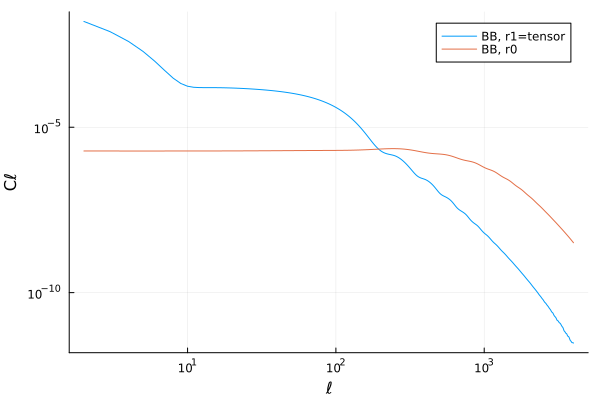

In [16]:
plot(
    xscale=:log, yscale=:log,
    xlabel="ℓ", ylabel="Cℓ",
    legend=:best
)

plot!(cl_r1.ell[3:end], cl_r1.BB[3:end], label="BB, r1=tensor")
plot!(cl_r0.ell[3:end], cl_r0.BB[3:end], label="BB, r0")

In [22]:
est_cont = BBClModel(100, cl_r0.BB, reffpath_r0, reffpath_r1)

BBClModel(100, [2, 3, 4, 5, 6, 7, 8, 9, 10, 11  …  91, 92, 93, 94, 95, 96, 97, 98, 99, 100], [1.9125178317013703e-6, 1.911056991117451e-6, 1.910213997088738e-6, 1.9099501033058364e-6, 1.9100883333825943e-6, 1.910458592516767e-6, 1.910987177947371e-6, 1.911624223124349e-6, 1.9123559920798216e-6, 1.913172806169755e-6  …  1.987016075900096e-6, 1.987494297675321e-6, 1.9879863189651542e-6, 1.9884909469076806e-6, 1.989013959346464e-6, 1.989547146542397e-6, 1.9901027748454527e-6, 1.990672678274675e-6, 1.991255663578069e-6, 1.991869277984755e-6], [0.01573738951913759, 0.007744758929384678, 0.0039061620576939416, 0.001966144818298148, 0.0009932055414534028, 0.000521167781283021, 0.0003034237451299622, 0.0002099121454007596, 0.00017338050016097066, 0.0001610965872861024  …  4.935415040792544e-5, 4.821830671166478e-5, 4.709801532763339e-5, 4.599347933189676e-5, 4.490500220309763e-5, 4.3832639665169855e-5, 4.27766209122152e-5, 4.173694240087323e-5, 4.071370799364037e-5, 3.970699391213225e-5], [1.9

In [ ]:
function calc_r_estimator(est_cont::BBClModel,; rresol, rmin, )
    cl_est = est_cont.cl_lens .+ r .* est_cont.cl_tens .+ est_cont.cl_sys
    return cl_est
end

calc_r_estimator (generic function with 1 method)

In [ ]:
calc_r_estimator(est_cont,;rresol=1e-5, rmin=1e-10, rmax=1e-5, )

0.004440848006571558

In [30]:
function test(;a, b=2,c=2)
    return a + b + c
end

test (generic function with 2 methods)

In [35]:
test(a=1)

5

In [18]:
A.ell

99-element Vector{Int64}:
   2
   3
   4
   5
   6
   7
   8
   9
  10
  11
   ⋮
  92
  93
  94
  95
  96
  97
  98
  99
 100

In [20]:
A.cl_sys

99-element Vector{Float64}:
 1.9125178317013703e-6
 1.911056991117451e-6
 1.910213997088738e-6
 1.9099501033058364e-6
 1.9100883333825943e-6
 1.910458592516767e-6
 1.910987177947371e-6
 1.911624223124349e-6
 1.9123559920798216e-6
 1.913172806169755e-6
 ⋮
 1.987494297675321e-6
 1.9879863189651542e-6
 1.9884909469076806e-6
 1.989013959346464e-6
 1.989547146542397e-6
 1.9901027748454527e-6
 1.990672678274675e-6
 1.991255663578069e-6
 1.991869277984755e-6

In [21]:
cl_r0.BB

4001-element Vector{Float64}:
 0.0
 0.0
 1.9125178317013703e-6
 1.911056991117451e-6
 1.910213997088738e-6
 1.9099501033058364e-6
 1.9100883333825943e-6
 1.910458592516767e-6
 1.910987177947371e-6
 1.911624223124349e-6
 ⋮
 3.2537049404875697e-9
 3.2493690119318855e-9
 3.2447141162793005e-9
 3.2403901479432343e-9
 3.2357514568773597e-9
 3.23144334931799e-9
 3.2268129613353506e-9
 3.222520677398133e-9
 3.2179064226481268e-9

In [89]:
cl_r0.BB

4001-element Vector{Float64}:
 0.0
 0.0
 1.9125178317013703e-6
 1.911056991117451e-6
 1.910213997088738e-6
 1.9099501033058364e-6
 1.9100883333825943e-6
 1.910458592516767e-6
 1.910987177947371e-6
 1.911624223124349e-6
 ⋮
 3.2537049404875697e-9
 3.2493690119318855e-9
 3.2447141162793005e-9
 3.2403901479432343e-9
 3.2357514568773597e-9
 3.23144334931799e-9
 3.2268129613353506e-9
 3.222520677398133e-9
 3.2179064226481268e-9

In [ ]:
ell = collect(3:100)
cl_r1.ell[ell]

99-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
  ⋮
 91
 92
 93
 94
 95
 96
 97
 98
 99

In [43]:
fname = "/Users/naganoyuukana/Desktop/r_estimator.jl/datautils/Cls_Planck2018_for_PTEP_2020_tensor_r1.fits"


"/Users/naganoyuukana/Desktop/r_estimator.jl/datautils/Cls_Planck2018_for_PTEP_2020_tensor_r1.fits"